## Imports

In [51]:
import torch
import torch.nn as nn
import json
from transformers import MarianTokenizer 
import sentencepiece as sp
from torch.utils.data import Dataset, DataLoader
import time
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

## Remove randomness and set cuda

In [43]:
SEED = 14
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data Processing

In [44]:
DEV_PATH = "data/llm/development.json"
EVAL_PATH = "data/llm/evaluation.json"

# English = "data/llm/OpenSubtitles.en-ko.en"
# Korean = "data/llm/OpenSubtitles.en-ko.ko"
# check_dash(Korean,"ko", "data/llm/korean")
# # check_dash(English,"en", "data/llm/english")
# def check_dash(path,language, new_path):
#     """This functions checks for a dash in the middle of the sentence with spaces on 
#     either side. This is a common error in the data.
#     example: "- 뭐요? - 멈춰"?
#     We want to add a newline before the dash in the middle of the sentence.
#     """
#     # First create/clear the files
#     f = open(new_path + f".{language}", "w")
#     data = get_data(path)
#     count = 0
#     next_count = 1
#     for sentence in data:
#         if " - " in sentence:
#             sentence = sentence.replace(" - ", f"\n{count+1} ")
#             next_count += 1
#         if "- " in sentence:
#             sentence = sentence.replace("- ", "")
#         f.write(f"{count} " + sentence)
#         count = next_count
#         next_count += 1
    
def get_data(path):
    with open(path, "r") as file:
        data = json.load(file)
    return data

def make_plain_text(data, path):
    f = open(path + ".en", "w")
    g = open(path + ".ko", "w")
    for group in data:
        sentences = group["text"]
        for sentence in sentences:
            f.write(sentence["en_text"] + "\n")
            g.write(sentence["ko_text"] + "\n")
    f.close()
    g.close()
# test = get_data(TEST_PATH)
train_json = get_data(DEV_PATH)
test_json = get_data(EVAL_PATH)
make_plain_text(train_json, "data/llm/development")
make_plain_text(test_json, "data/llm/evaluation")

# bpe tokenization
!mkdir -p models/tokens
vocab_size = 2000
threads = 16

# this is used latter in batches, apparently it crashes if batches have different length sentences inside of themselves
padding_id = 3 

sp.SentencePieceTrainer.train(input="data/llm/development.en", model_prefix="models/tokens/english", vocab_size=vocab_size, model_type="bpe", num_threads=threads, bos_id=0, eos_id=1, unk_id=2, pad_id=padding_id) # force the padding id because it didn't automatically make it
sp.SentencePieceTrainer.train(input="data/llm/development.ko", model_prefix="models/tokens/korean", vocab_size=vocab_size, model_type="bpe", num_threads=threads, bos_id=0, eos_id=1, unk_id=2, pad_id=padding_id) # force the padding id because it didn't automatically make it
english_tokenizer = sp.SentencePieceProcessor()
english_tokenizer.load("models/tokens/english.model")
korean_tokenizer = sp.SentencePieceProcessor()
korean_tokenizer.load("models/tokens/korean.model")
assert(english_tokenizer.pad_id() == 3)

## Build the vocabs of each language

In [45]:
def load_sentencepiece_vocab(model_file):
    spp = sp.SentencePieceProcessor()
    spp.load(model_file)
    vocab = {}
    reverse_vocab = {}
    for i in range(spp.get_piece_size()):
        vocab[spp.id_to_piece(i)] = i
        reverse_vocab[i] = spp.id_to_piece(i)
    return vocab, reverse_vocab

# Load English and Korean vocabularies
english_vocab, reverse_english_vocab = load_sentencepiece_vocab("models/tokens/english.model")
korean_vocab, reverse_korean_vocab = load_sentencepiece_vocab("models/tokens/korean.model")

print("English vocab size:", len(english_vocab))
print("Korean vocab size:", len(korean_vocab))
print("reverse vocab size:", len(reverse_english_vocab))


English vocab size: 2000
Korean vocab size: 2000
reverse vocab size: 2000


## Dataset and DataLoader

In [46]:
class TranslationDataset(Dataset):
    def __init__(self, english_path, korean_path, english_tokenizer, korean_tokenizer):
        with open(english_path, "r") as file:
            self.english_sentences = file.readlines()
        with open(korean_path, "r") as file:
            self.korean_sentences = file.readlines()
        assert len(self.english_sentences) == len(self.korean_sentences)
        self.english_tokenizer = english_tokenizer
        self.korean_tokenizer = korean_tokenizer
        
    def __len__(self):
        return len(self.english_sentences)
    
    def __getitem__(self, i):
        english_sentence = self.english_sentences[i]
        korean_sentence = self.korean_sentences[i]
        english_tokens = self.english_tokenizer.encode(english_sentence)
        korean_tokens = self.korean_tokenizer.encode(korean_sentence)
        return torch.tensor(english_tokens), torch.tensor(korean_tokens)
    
# This is the padding class which allows us to use batches with dynamic sentence lengths
class Padding():
    def __init__(self, padding_id):
        self.padding_id = padding_id
    def __call__(self, batch):
        english, korean = zip(*batch)
        english = pad_sequence(english, batch_first=True, padding_value=self.padding_id)
        korean = pad_sequence(korean, batch_first=True, padding_value=self.padding_id)
        return english, korean
    
padding = Padding(padding_id)
dataset = TranslationDataset("data/llm/development.en", "data/llm/development.ko", english_tokenizer, korean_tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=padding)

## Model

In [47]:
# Note I took a lot of inspiration from https://medium.com/@WamiqRaza/sequence-to-sequence-learning-with-neural-networks-30028d824591
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers=layers, batch_first=True)
        
    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.rnn(x)
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, layers):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers=layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, hidden, cell):
        x = self.embedding(x)
        output, (hidden, cell) = self.rnn(x, (hidden, cell))
        prediction = self.linear(output)
        return prediction, hidden, cell
    
class Model(nn.Module):
    def __init__(self, encoder, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, english, korean):
        hidden, cell = self.encoder(english)
        prediction, _, _ = self.decoder(korean, hidden, cell)
        return prediction
    
embedding_size = 256
hidden_size = 512
layers = 2
encoder = Encoder(len(english_vocab), embedding_size, hidden_size, layers).to(device)
decoder = Decoder(len(korean_vocab), embedding_size, hidden_size, layers).to(device)
model = Model(encoder, decoder)

## Training

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
!mkdir -p checkpoints/llm
train_history = {}
model.train()
for epoch in range(epochs):
    start = time.time()
    total_loss = 0
    train_history[epoch] = []
    for i, (english, korean) in enumerate(dataloader):
        english, korean = english.to(device), korean.to(device)
        optimizer.zero_grad()
        output = model(english, korean)
        output = output.view(-1, output.shape[2])
        korean = korean.view(-1)
        loss = criterion(output, korean)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(f"Batch: {i+1}/{len(dataloader)}, Loss: {loss.item()}")
        train_history[epoch].append(loss.item())
    end = time.time()
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {total_loss}, Time: {end-start}")
    # save checkpoint
    torch.save(model.state_dict(), f"checkpoints/llm/epoch_{epoch+1}.pt")

Batch: 1/158, Loss: 7.640931606292725
Batch: 2/158, Loss: 7.1426801681518555
Batch: 3/158, Loss: 6.375210762023926
Batch: 4/158, Loss: 4.94036865234375
Batch: 5/158, Loss: 3.787696599960327
Batch: 6/158, Loss: 5.6587748527526855
Batch: 7/158, Loss: 4.131099700927734
Batch: 8/158, Loss: 3.511444091796875
Batch: 9/158, Loss: 4.775665283203125
Batch: 10/158, Loss: 3.852273464202881
Batch: 11/158, Loss: 3.769291639328003
Batch: 12/158, Loss: 4.654695510864258
Batch: 13/158, Loss: 3.414902925491333
Batch: 14/158, Loss: 3.373291254043579
Batch: 15/158, Loss: 4.530930519104004
Batch: 16/158, Loss: 3.7246270179748535
Batch: 17/158, Loss: 4.506260871887207
Batch: 18/158, Loss: 3.6151745319366455
Batch: 19/158, Loss: 3.9277796745300293
Batch: 20/158, Loss: 4.056972503662109
Batch: 21/158, Loss: 4.138716220855713
Batch: 22/158, Loss: 3.97751784324646
Batch: 23/158, Loss: 3.9993715286254883
Batch: 24/158, Loss: 3.650805711746216
Batch: 25/158, Loss: 3.268461227416992
Batch: 26/158, Loss: 3.4997327

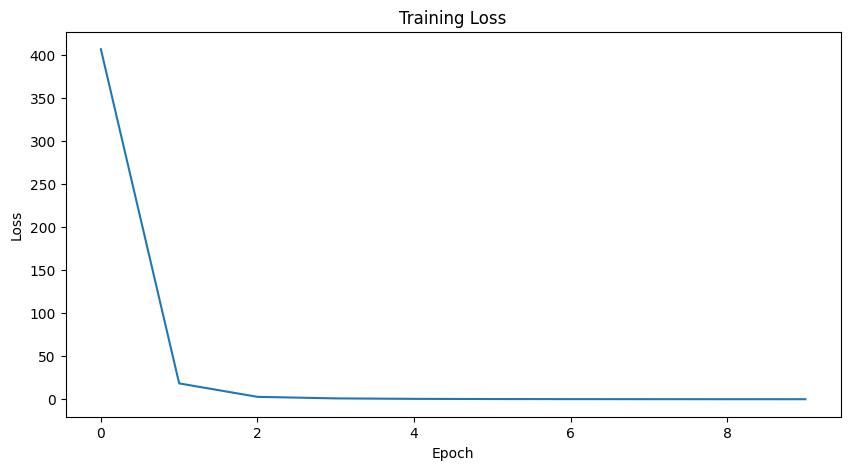

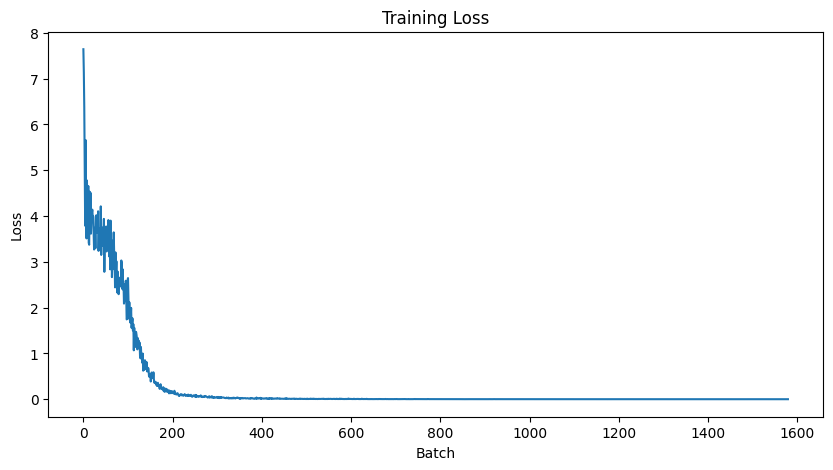

In [55]:
# Save the training history
with open("checkpoints/llm/train_history.json", "w") as file:
    json.dump(train_history, file)
    
# Plot the training history
plt.figure(figsize=(10, 5))
epoch_loss = []
for epoch, loss in train_history.items():
    # sum the loss of each batch
    epoch_loss.append(sum(loss))
running_batch_loss = []
for epoch, loss in train_history.items():
    running_batch_loss.extend(loss)

# plot sum of epoch loss (or do we do average? Can one of you confirm?)
plt.plot(epoch_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

# plot running batch loss
plt.figure(figsize=(10, 5))
plt.plot(running_batch_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


## Evaluation

In [58]:
# Load the model and set it to evaluation mode
model2 = Model(encoder, decoder).to(device)
model2.load_state_dict(torch.load("checkpoints/llm/epoch_10.pt"))
model2.eval()

# Load the evaluation dataset
eval_dataset = TranslationDataset("data/llm/evaluation.en", "data/llm/evaluation.ko", english_tokenizer, korean_tokenizer)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=True, collate_fn=padding)

# Evaluate the model
total_loss = 0

for i, (english, korean) in enumerate(eval_dataloader):
    english, korean = english.to(device), korean.to(device)
    output = model2(english, korean)
    output = output.view(-1, output.shape[2])
    korean = korean.view(-1)
    loss = criterion(output, korean)
    total_loss += loss.item()
    print(f"Batch: {i+1}/{len(eval_dataloader)}, Loss: {loss.item()}")
print(f"Total Loss: {total_loss}")

Batch: 1/151, Loss: 0.00047055541654117405
Batch: 2/151, Loss: 0.0006839927518740296
Batch: 3/151, Loss: 0.0006065939087420702
Batch: 4/151, Loss: 0.007105179131031036
Batch: 5/151, Loss: 0.0006620482308790088
Batch: 6/151, Loss: 0.00075148930773139
Batch: 7/151, Loss: 0.0006550325197167695
Batch: 8/151, Loss: 0.0005484517896547914
Batch: 9/151, Loss: 0.000728233193513006
Batch: 10/151, Loss: 0.0005002414691261947
Batch: 11/151, Loss: 0.0005790849099867046
Batch: 12/151, Loss: 0.0005756817990913987
Batch: 13/151, Loss: 0.0005467485752888024
Batch: 14/151, Loss: 0.0006934659904800355
Batch: 15/151, Loss: 0.0005279876058921218
Batch: 16/151, Loss: 0.0006514612468890846
Batch: 17/151, Loss: 0.0009132206905633211
Batch: 18/151, Loss: 0.00045256136218085885
Batch: 19/151, Loss: 0.0009643862722441554
Batch: 20/151, Loss: 0.0008420009980909526
Batch: 21/151, Loss: 0.0007838006713427603
Batch: 22/151, Loss: 0.000751386396586895
Batch: 23/151, Loss: 0.0045995269902050495
Batch: 24/151, Loss: 0.

In [68]:
# test inference
sentence = "They"
sentence = english_tokenizer.encode(sentence)
sentence = torch.tensor(sentence).unsqueeze(0).to(device)
hidden, cell = model2.encoder(sentence)
start = torch.tensor([[korean_tokenizer.bos_id()]]).to(device)
output = []
for _ in range(20):
    prediction, hidden, cell = model2.decoder(start, hidden, cell)
    prediction = prediction.argmax(2)
    output.append(prediction.item())
    start = prediction
    if prediction.item() == korean_tokenizer.eos_id():
        break
output = [reverse_korean_vocab[i] for i in output]
print("".join(output))

개개개개개개개개개개개개개개개개개개개개


## Trying to debug why our results are so bad

In [90]:
sentence = "they"
print(str(english_tokenizer.encode(sentence)))
print(english_tokenizer.decode(english_tokenizer.encode(sentence)))
sentence = "They"
print(str(english_tokenizer.encode(sentence)))
print(english_tokenizer.decode(english_tokenizer.encode(sentence)))

# setting hidden to 0 doesn't change anything
# TODO: Change the padding token in the padding class to be end of sentence?
# TODO: More data?

# make sure that the target loader works
loader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=padding)
for english, korean in loader:
    print(english)
    for i in english[0]:
        print(reverse_english_vocab[i.item()], end="")
    print(korean)
    for i in korean[0]:
        print(reverse_korean_vocab[i.item()], end="")
    break
    
# Maybe checkpoint 1 is better because of overfitting?
model3 = Model(encoder, decoder).to(device)
model3.load_state_dict(torch.load("checkpoints/llm/epoch_1.pt"))
model3.eval()
sentence = "home"
print(str(english_tokenizer.encode(sentence)))
assert str(english_tokenizer.encode(sentence)) != str(3)
sentence = torch.tensor(english_tokenizer.encode(sentence)).unsqueeze(0).to(device)
hidden, cell = model3.encoder(sentence)
start = torch.tensor([[korean_tokenizer.bos_id()]]).to(device)
output = None
for _ in range(1):
    prediction, hidden, cell = model3.decoder(start, hidden, cell)
    prediction = prediction.argmax(2)
    output = prediction.item() 
    start = prediction
    if prediction.item() == korean_tokenizer.eos_id():
        break
assert reverse_korean_vocab[output] == "집"




[293]
they
[1590]
They
tensor([[1329,   13,  637, 1938,   34,   50,   40,  354,   47,   34,  351, 1936,
          141,  392,    8, 1442,   49,   22,   11,  537,   38, 1150,  285, 1495,
           72,    8,    4,  436,   58,   14,  553,  616,  769, 1445,  175,   25,
          268, 1952,   38,  846,   22,  491, 1952,  176,   47,  161,   90, 1476,
           90,   83,   11,  296, 1938, 1954],
        [  63, 1961, 1945,   90, 1263,   22,   26,  579,  955,   75, 1394,   29,
          418,    6,  257,  345,   72,    6,  922, 1959, 1942,  354,    4,  436,
         1070,  263, 1954,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3]])
▁What▁needs▁to▁be▁done▁is▁to▁scoop▁up▁the▁boiled▁soup▁and▁side▁dishes▁on▁the▁table▁that▁wife▁made▁before▁she▁goes▁out,▁and▁feed▁them,▁which▁is▁not▁as▁easy▁as▁it▁sounds.tensor([[  29,  832,  763,  180,  899,  141,   16,  757, 1760,  835,

AssertionError: 